# Logistic Regression

We would like to perform hyperparameter selection over the set of all logistic regression models.

Logistic regression with $K > 2$ classes is actually broken into two "flavours":
- **one-versus-all**: Fit a separate binary classifier for each class against the rest, and classify according to the highest score.
- **multinomial**: Fit a single classifier with $K$ outputs (one of them is 1), and take the softmax thereof. This is the flavour we learn in STAT 441, and is the default used by `sklearn`.

We choose to focus on multinomial logistic regression here.

## Setup

In [1]:
from sklearn.linear_model import LogisticRegression

from tune import (
    Constant,
    outer_cv,
    Real,
    SKBayesTuner,
)

Using 5 cores


## Search Space

For regularization, ElasticNet encompasses both L1 and L2 penalties (and with a weak enough regularization term, no-penalty as well).
We thus parameterize the search space by the ratio of the L1 and L2 penalties, and the coefficient C representing the extent of regularization.

Unfortunately, the only solver in `sklearn` that works with ElasticNet is the `saga` solver, and that solver is quite sluggish.

In [ ]:
space = dict(
    # constants
    multi_class=Constant("multinomial"),
    penalty=Constant("elasticnet"),
    solver=Constant("saga"),
    max_iter=Constant(9001),  # practically unlimited
    random_state=Constant(441),
    warm_start=Constant(True),  # try to speed up optimization
    
    # variables
    C=Real(low=1e-4, high=1e4, prior="log-uniform"),
    l1_ratio=Real(low=0.0, high=1.0, prior="uniform"),
)

## Base

Outer CV using 5 cores


[INFO/ForkPoolWorker-6] child process calling self.run()
[INFO/ForkPoolWorker-7] child process calling self.run()
[INFO/ForkPoolWorker-8] child process calling self.run()
[INFO/ForkPoolWorker-9] child process calling self.run()
[INFO/ForkPoolWorker-10] child process calling self.run()
/home/xujustinj/projects/pokemon-type-classification/.venv/lib/python3.10/site-packages/joblib/parallel.py:775: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/home/xujustinj/projects/pokemon-type-classification/.venv/lib/python3.10/site-packages/joblib/parallel.py:775: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = self._backend.configure(n_jobs=self.n_jobs, parallel=self,
/home/xujustinj/projects/pokemon-type-classification/.venv/lib/python3.10/site-packages/joblib/parallel.py:775: UserWarning: Loky-backed parallel loops cannot

<Figure size 1000x1000 with 0 Axes>

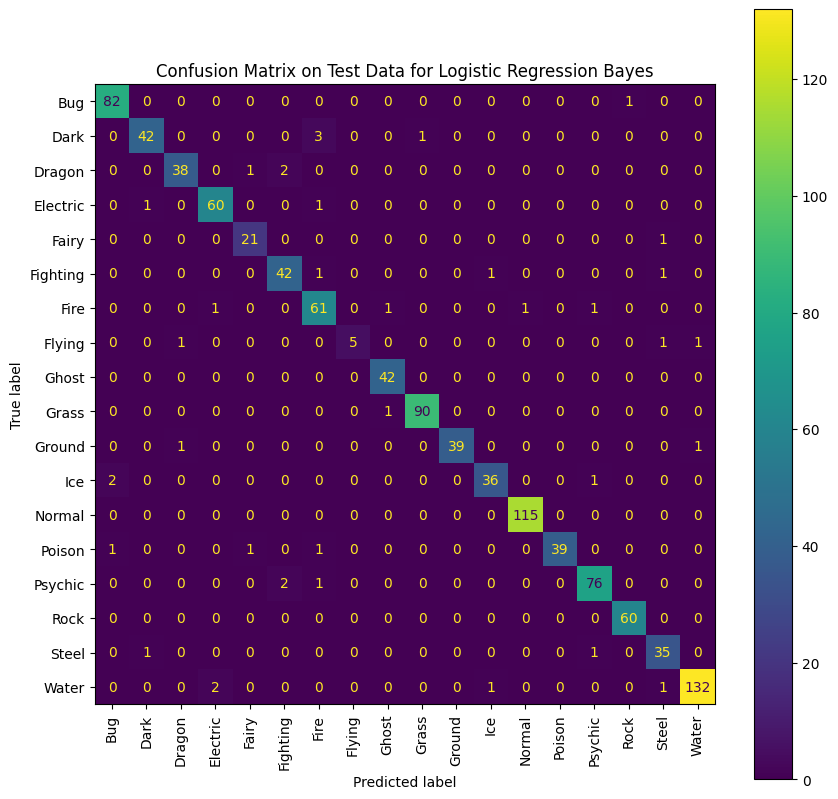

0.9630151207402392

In [3]:
outer_cv(
    tuner=SKBayesTuner(LogisticRegression, duplicate=False),
    search=space,
    name="Logistic Regression",
    duplicate=False,
    hard_mode=False,
)

## Hard

Outer CV using 1 cores


[INFO/LokyProcess-2] child process calling self.run()
[INFO/LokyProcess-3] child process calling self.run()
[INFO/LokyProcess-1] child process calling self.run()
[INFO/LokyProcess-4] child process calling self.run()
[INFO/LokyProcess-5] child process calling self.run()
[INFO/MainProcess] 1  Tuned model in 1142.2958369255066 seconds
[INFO/MainProcess] 1  Saved to cache at ../models/logistic_regression_hard/cv-1.mdl
[INFO/MainProcess] 1  Best configuration: OrderedDict([('C', 539.0473923776119), ('l1_ratio', 0.0)])
[INFO/MainProcess] 1	Accuracy: 0.3886255924170616
[INFO/MainProcess] 2  Tuned model in 1017.3432660102844 seconds
[INFO/MainProcess] 2  Saved to cache at ../models/logistic_regression_hard/cv-2.mdl
[INFO/MainProcess] 2  Best configuration: OrderedDict([('C', 3.6471727702197687), ('l1_ratio', 0.949833382858919)])
[INFO/MainProcess] 2	Accuracy: 0.3933649289099526
[INFO/MainProcess] 3  Tuned model in 1184.5761201381683 seconds
[INFO/MainProcess] 3  Saved to cache at ../models/log

<Figure size 1000x1000 with 0 Axes>

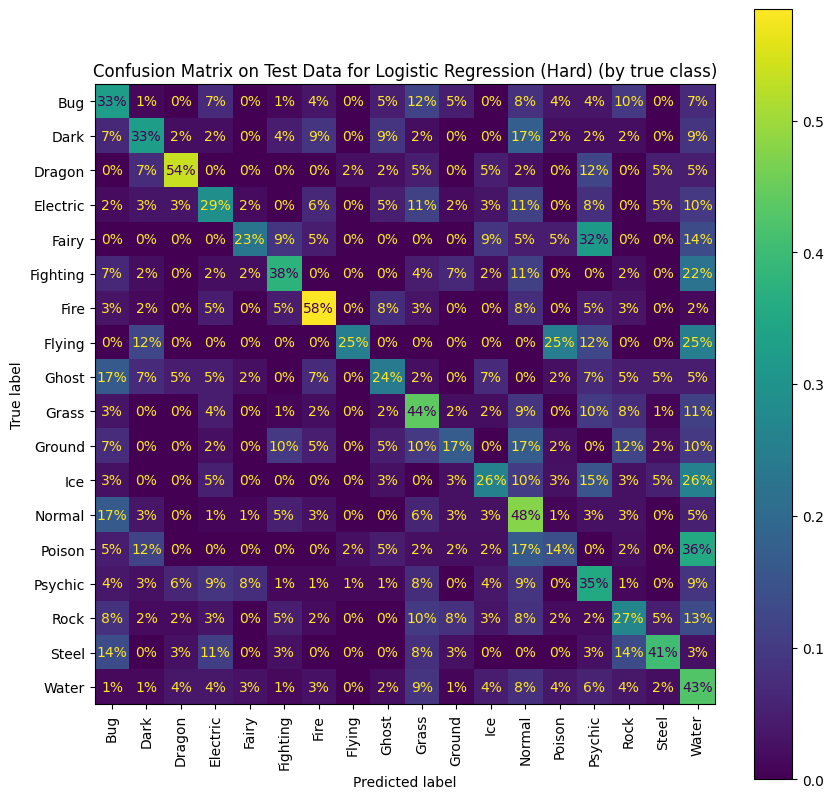

<Figure size 1000x1000 with 0 Axes>

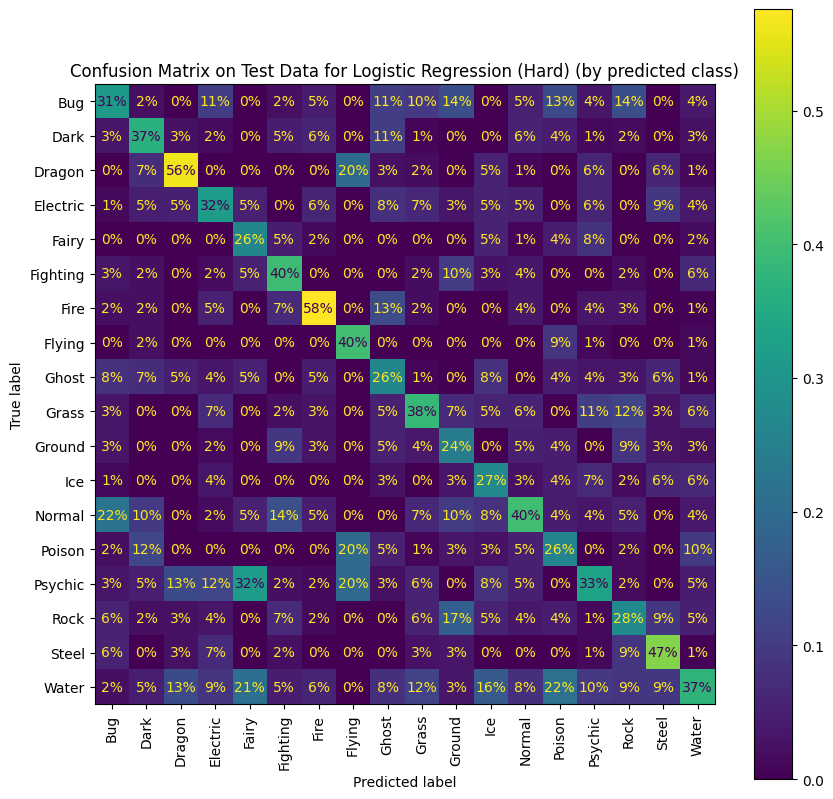

0.36902730760550667

In [2]:
outer_cv(
    tuner=SKBayesTuner(LogisticRegression, duplicate=False),
    search=space,
    name="Logistic Regression",
    duplicate=False,
    hard_mode=True,
)

## Duplication

In [ ]:
outer_cv(
    tuner=SKBayesTuner(LogisticRegression, duplicate=True),
    search=space,
    name="Logistic Regression",
    duplicate=True,
    hard_mode=False,
)

## Duplication, Hard

In [ ]:
outer_cv(
    tuner=SKBayesTuner(LogisticRegression, duplicate=True),
    search=space,
    name="Logistic Regression",
    duplicate=True,
    hard_mode=True,
)